In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow.lite as tflite 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time


# INITIALIZATION
resnet = tflite.Interpreter('./models/resnet.tflite')
resnet.allocate_tensors()

input_index = resnet.get_input_details()[0]['index']
output_index = resnet.get_output_details()[0]['index']

2024-04-07 18:24:10.210526: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 18:24:10.210554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 18:24:10.211407: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [2]:
BLOCK_SIZE, C = 33, 5
TEMPLATE_SIZE = (600, 600)
TEMPLATE_FILENAME = './template.jpg'

In [3]:
def find_max_area_contour(contours):
    """
    :param contours: list of contours found by cv2.findContours
    :return: index of the contour which has the greatest area
    """
    max_area = 0
    j = 0
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area > max_area:
            max_area = area
            j = i
    return j

In [4]:
def get_corners(contour):
    """
    This function takes contours to find 4 corners bounding its area
    :param contour:
    :return: ndarray with value of 4 corners
    :raise: ValueError if more than 4 corners are found
    """
    # Approximate contour
    epsilon = 0.03 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Find convex hull
    hull = cv2.convexHull(approx)
    hull = np.squeeze(hull, 1)

    if hull.shape[0] != 4:
        raise ValueError(f'We need exactly 4 points but {hull.shape[0]} is found')

    corners = []
    for corner in hull:
        x, y = corner[0], corner[1]
        corners.append([x, y])
    corners = np.array(corners)
    return corners


def get_sorted_corners(corners, dsize=None):
    """
    Corners are reordered, Top-left, Bottom-left, Top-right, Bottom-right.
    :param corners:
    :param dsize: if given, it scales to_pts
    :return: (sorted_corners, to_pts)
    to_pts helps to map each corner to a new point
    """
    center = np.mean(corners, axis=0)
    result = [[], [], [], []]
    for corner in corners:
        if corner[0] < center[0] and corner[1] < center[1]:
            result[0].extend(corner)
        elif corner[0] < center[0] and corner[1] >= center[1]:
            result[1].extend(corner)
        elif corner[0] >= center[0] and corner[1] < center[1]:
            result[2].extend(corner)
        elif corner[0] >= center[0] and corner[1] >= center[1]:
            result[3].extend(corner)
        else:
            raise ValueError("Values do not match")
    result = np.array(result, dtype='float32')
    to_pts = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype='float32')
    if dsize is not None:
        to_pts[:, 0] *= dsize[0]
        to_pts[:, 1] *= dsize[1]
    return result, to_pts


def draw_max_contour(img):
    """
    Given an image, it finds a contour with maximum area and draw it on the image
    :param img:
    :return: a new image with drawing of the maximum contour found
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, BLOCK_SIZE, C)
    contours, hier = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    j = find_max_area_contour(contours)
    new_img = img.copy()
    _ = cv2.drawContours(new_img, contours, j, (0, 255, 0), 5)
    return new_img

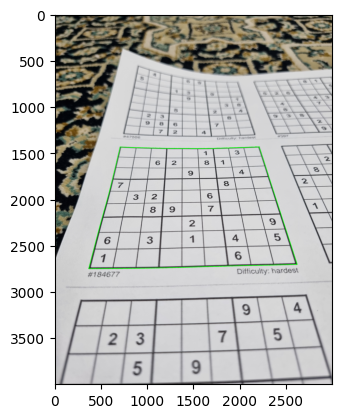

In [5]:
img = cv2.imread('./Samples/sample8.jpg')
plt.imshow(draw_max_contour(img[..., ::-1]))
plt.savefig('./docs/fig1.jpg', dpi=400)

In [6]:
def alignSudokuPaper(img):
    """
    Given image of a sudoku, this function aligns the sudoku by changing the perspective
    :param img:
    :return: aligned image
    """
    if np.ndim(img) != 2:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else: gray = img
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, BLOCK_SIZE, C)
    contours, hier = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    j = find_max_area_contour(contours)
    corners = get_corners(contours[j])
    corners, to_pts = get_sorted_corners(corners, TEMPLATE_SIZE)
    M = cv2.getPerspectiveTransform(corners, to_pts)
    new_img = cv2.warpPerspective(img.copy(), M, TEMPLATE_SIZE, flags=cv2.INTER_CUBIC)
    return new_img

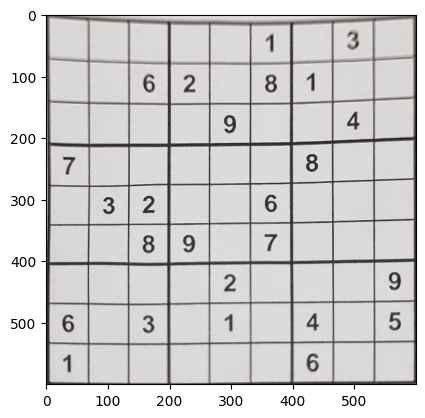

In [7]:
new_img = alignSudokuPaper(img)
plt.imshow(new_img)
plt.savefig('./docs/fig2.jpg', dpi=400)

## Preprocessing Gridlines

In [8]:
def img_with_lines(img, template_file_name='./template.jpg'):
    """
    Given an image and the template file, it tries to align with the template file and draw the lines
    :param img:
    :param template_file_name:
    :return: new image
    """
    new_img = alignSudokuPaper(img)
    
    if np.ndim(new_img) != 2: 
        new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    _, new_img = cv2.threshold(new_img, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Reading template file
    template = cv2.imread(template_file_name, 0)
    _, template = cv2.threshold(template, 60, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    template = cv2.morphologyEx(template, cv2.MORPH_CROSS, np.ones((5, 5)))

    # Composing template and our image
    new_img = cv2.bitwise_or(template, new_img)

    height, width = template.shape
    edges = cv2.Canny(new_img, 90, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 250, minLineLength=100, maxLineGap=width)

    X1, X2, Y1, Y2 = [], [], [], []

    lines = np.squeeze(lines, 1)

    for line in lines:
        x1, y1, x2, y2 = line
        X1.append(x1)
        X2.append(x2)
        Y1.append(y1)
        Y2.append(y2)

        cv2.line(new_img, (x1, y1), (x2, y2), (255,), 3)

    return 255 - new_img

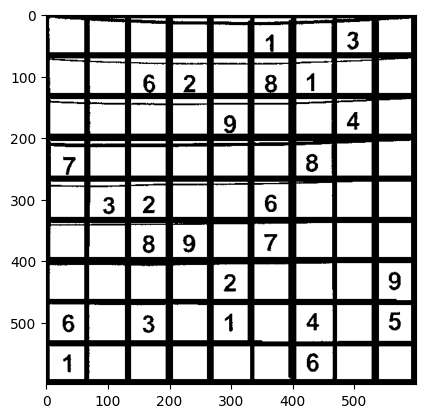

In [9]:
new_img = img_with_lines(img, TEMPLATE_FILENAME)
plt.imshow(new_img, cmap='gray')
plt.savefig('./docs/fig3.jpg', dpi=400)

## Parsing the gridlines

In [10]:
def convert_to_relative_pos(centers, ignore_pixel_difference=10):
    """
    Given a dictionary of centers with values being (x, y) to specify the point, this function finds relative position
    of each point to another.
    :param centers: a dictionary
    :param ignore_pixel_difference: integer representing how many pixels to ignore
    :return: two dictionaries, x_dict, y_dict
    x_dict: key is the x coordinate of each point and value is the row number that point exists on
    y_dict: key is the y coordinate of each point and value is the column number that point exists on
    """
    arr = np.array(list(centers.values()))

    xs = arr[:, 0].copy().astype('int32')
    xs.sort()
    cnt = 0
    current_x = xs[0]
    x_dict = {current_x: cnt}
    for x in xs[1:]:
        difference = np.abs(current_x - x)
        if difference <= ignore_pixel_difference:
            x_dict[x] = cnt
        else:
            current_x = x
            cnt += 1
            x_dict[x] = cnt

    ys = arr[:, 1].copy().astype('int32')
    ys.sort()
    cnt = 0
    current_y = ys[0]
    y_dict = {current_y: cnt}
    for y in ys[1:]:
        difference = np.abs(current_y - y)
        if difference <= ignore_pixel_difference:
            y_dict[y] = cnt
        else:
            current_y = y
            cnt += 1
            y_dict[y] = cnt

    return x_dict, y_dict


def get_relative_pos(center, x_dict, y_dict):
    """
    Given a center point with (x, y) values, it returns its associative row number and column number
    :param center:
    :param x_dict:
    :param y_dict:
    :return: tuple(row, column)
    """
    x = center[0]
    y = center[1]
    return x_dict[x], y_dict[y]

In [11]:
def find_squares(contours):
    """
    given contours, it finds the index of the contours that are related to the squares on the sudoku grid
    :param contours:
    :return: list of indices
    :raise ValueError if number of squares found on the grid is not 81
    """
    square_contours = []
    avg_contour_area = np.mean([cv2.contourArea(contour) for contour in contours])
    for i in range(len(contours)):
        contour = contours[i]
        # Approximate contour
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Find convex hull
        hull = cv2.convexHull(approx)
        hull = np.squeeze(hull, 1)
        if hull.shape[0] == 4:
            area = cv2.contourArea(contour)
            if area < avg_contour_area * 0.6: continue
            if area > 7 * avg_contour_area: continue
            square_contours.append(i)

    if len(square_contours) != 81:
        raise ValueError(f'Found {len(square_contours)} number of squares on the sudoku grid which should be 81')
    return square_contours


def sort_by_position(contour_indices, contours):
    """
    Given contour indicies and the contours themselves, it sorts the indices with respect to their relative centers
    :param contour_indices:
    :param contours:
    :return: list of sorted contour indices, dict(centers) key=index, value=(x, y)
    """
    centers = {}
    for s in contour_indices:
        cont = contours[s]
        corners = get_corners(cont)
        center = np.mean(corners, axis=0)
        centers[s] = np.array(center, dtype='int32')

    x_dict, y_dict = convert_to_relative_pos(centers)
    sorted_squares = sorted(contour_indices, key=lambda pos: get_relative_pos(centers[pos], x_dict, y_dict)[::-1])
    return sorted_squares, centers


def get_square_img(img, contour):
    """
    Given an image and the contour that specifies the grid cell of the sudoku grid, it crops and resizes the cell
    :param img:
    :param contour:
    :return: image of the cell
    """
    retr_img = img.copy()
    if np.ndim(retr_img) < 3:
        retr_img = cv2.cvtColor(retr_img, cv2.COLOR_GRAY2BGR)
    width, height = 28, 28
    corners, pts = get_sorted_corners(get_corners(contour), (width, height))
    M = cv2.getPerspectiveTransform(corners, pts)
    retr_img = cv2.warpPerspective(retr_img, M, (width, height))
    return retr_img

In [12]:
def classify_img(retr_img):
    """
    Given some image of the sudoku grid cell, it calculates what number is inside
    :param retr_img:
    :return: an integer between 0 and 9
    """
    to_predict = retr_img.copy()
    if np.ndim(to_predict) > 2:
        to_predict = cv2.cvtColor(to_predict, cv2.COLOR_BGR2GRAY)

    _, to_predict = cv2.threshold(to_predict, 200, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    to_predict = cv2.copyMakeBorder(to_predict, 3, 3, 3, 3, cv2.BORDER_CONSTANT, 0)
    to_predict = cv2.resize(to_predict, (28, 28), interpolation=cv2.INTER_CUBIC)
    to_predict = np.reshape(to_predict, (1, 28, 28, 1))
    to_predict = to_predict.astype('float32')
    resnet.set_tensor(input_index, to_predict)
    resnet.invoke()
    outputs = resnet.get_tensor(output_index)
    outputs = np.argmax(outputs, axis=-1)[0]
    return outputs

In [13]:
def get_sudoku_matrix(img, contour_sorted_indicies, contours):
    """
    Given the image of the sudoku grid and contours, it calculates what number is inside each cell in order of sorted indices
    given
    :param img:
    :param contour_sorted_indicies:
    :param contours:
    :return: a ndarray with shape of (9, 9) replicating the sudoku image (img)
    """
    sudoku = np.zeros((9, 9), dtype='int32')
    temp_img = img.copy()

    cnt = 0
    for i in range(9):
        for j in range(9):
            contour_idx = contour_sorted_indicies[cnt]
            contour = contours[contour_idx]
            retr_img = get_square_img(temp_img, contour)
            num = classify_img(retr_img)
            if num == 10: num = 0
            sudoku[i, j] = num
            cnt += 1
    return sudoku

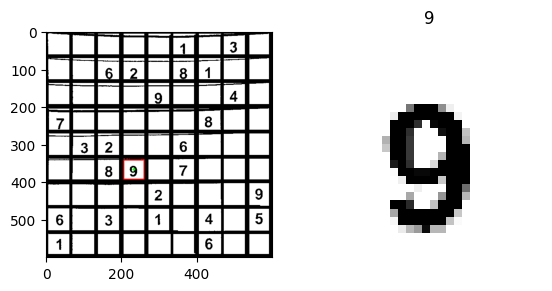

In [14]:
contours, hier = cv2.findContours(new_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
square_contours = find_squares(contours)
square_contours, centers = sort_by_position(square_contours, contours)
test = new_img.copy()
test = cv2.cvtColor(test, cv2.COLOR_GRAY2BGR) 

i = 48
val = square_contours[i]
_ = cv2.drawContours(test, contours, val, (255, 0, 0), 2)
_ = cv2.drawMarker(test, centers[val].tolist(), (0, 255, 0), cv2.MARKER_CROSS, 5, 3)

plt.figure()
ax = plt.subplot(1, 2, 1)
ax.imshow(test)
ax = plt.subplot(1, 2, 2)
retr_img = get_square_img(new_img, contours[val])
outputs = classify_img(retr_img)
ax.imshow(retr_img);
ax.axis('off')
ax.set_title(outputs);
plt.savefig('./docs/fig4.jpg', dpi=400);

In [15]:
start = time.time()
sudoku = get_sudoku_matrix(new_img, square_contours, contours)
end = time.time()
print(f'Elasped time {int((end - start) * 1000)}ms')

Elasped time 135ms


In [16]:
for i in range(9):
    for j in range(9):
        if (j + 1) % 3 == 0:
            print(f'{sudoku[i, j]:>1}   ', end=' ')
        else:
            print(f'{sudoku[i, j]:>1}', end=' ')
    print()
    if (i + 1) % 3 == 0: print()

0 0 0    0 0 1    0 3 0    
0 0 6    2 0 8    1 0 0    
0 0 0    0 9 0    0 4 0    

7 0 0    0 0 0    8 0 0    
0 3 2    0 0 6    0 0 0    
0 0 8    9 0 7    0 0 0    

0 0 0    0 2 0    0 0 9    
6 0 3    0 1 0    4 0 5    
1 0 0    0 0 0    6 0 0    



In [17]:
def init_counts(sudoku):
    """
    This is a helper function to efficiently implement validate_sudoku
    """
    row_counts = np.zeros((9, 10), dtype='int32')
    column_counts = np.zeros((9, 10), dtype='int32')
    block_counts = np.zeros((3, 3, 10), dtype='int32')
    for i in range(9):
        for j in range(9):
            if sudoku[i, j] == 0: continue
            n = sudoku[i, j]    
            row_counts[i, n] += 1
            column_counts[j, n] += 1
            block_counts[i // 3, j // 3, n] += 1
    return row_counts, column_counts, block_counts

row_counts, column_counts, block_counts = init_counts(sudoku)
        

def validate_sudoku(sudoku, i, j):
    """
    Given sudoku grid, this function validates if sudoku is valid relative to the i'th row and j'th column
    :param sudoku: ndarray with shape of (9, 9)
    :param i:
    :param j:
    :return: boolean
    """
    n = sudoku[i, j]
    if row_counts[i, n] > 1: return False
    if column_counts[j, n] > 1: return False
    if block_counts[i // 3, j // 3, n] > 1: return False

    return True


def solve_sudoku(sudoku, i=0, j=0):
    """
    Given a sudoku grid, it solves the sudoku
    :param sudoku: ndarray with shape of (9, 9)
    :param i:
    :param j:
    :return: boolean
    """
    if j == 9:
        return solve_sudoku(sudoku, i=i + 1, j=0)
    if i == 9:
        return True
    if sudoku[i, j] != 0:
        return solve_sudoku(sudoku, i, j + 1)

    for n in range(1, 10):
        sudoku[i, j] = n
        row_counts[i, n] += 1
        column_counts[j, n] += 1
        block_counts[i // 3, j // 3, n] += 1
        valid = validate_sudoku(sudoku, i, j)

        if valid:
            result = solve_sudoku(sudoku, i, j + 1)
            if result: return True

        # Backtrack
        sudoku[i, j] = 0
        row_counts[i, n] -= 1
        column_counts[j, n] -= 1
        block_counts[i // 3, j // 3, n] -= 1

    return False

In [18]:
def solve_sudoku_with_image(sudoku, template_file_name='./template.jpg', margin=15):
    """
    Given a sudoku grid, it solves the sudoku
    :param sudoku: ndarray with shape of (9, 9)
    :param template_file_name: path to the template sudoku image
    :param margin: margin to the numbers in each cell
    :return: image
    """
    temp = cv2.imread('./template.jpg', 0)
    new_img = img_with_lines(temp, template_file_name)
    contours, hier = cv2.findContours(new_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    square_contours = find_squares(contours)
    square_contours, centers = sort_by_position(square_contours, contours)

    temp = cv2.cvtColor(temp, cv2.COLOR_GRAY2BGR)

    pre_complete = []
    flattened = [sudoku[i, j] for i in range(9) for j in range(9)]
    for i in range(81):
        n = flattened[i]
        if n == 0: continue
        x_c, y_c = centers[square_contours[i]]
        x_c, y_c = x_c - margin, y_c + margin
        _ = cv2.putText(temp, f'{n}', (x_c, y_c), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 0), 3)
        pre_complete.append(i)

    print('Solving ...')
    solve_sudoku(sudoku)
    flattened = [sudoku[i, j] for i in range(9) for j in range(9)]
    for i in range(81):
        if i in pre_complete: continue
        x_c, y_c = centers[square_contours[i]]
        x_c, y_c = x_c - margin, y_c + margin
        n = flattened[i]
        _ = cv2.putText(temp, f'{n}', (x_c, y_c), cv2.FONT_HERSHEY_PLAIN, 3, (55, 127, 200), 3)
    return temp

Solving ...
Solved in 1233ms


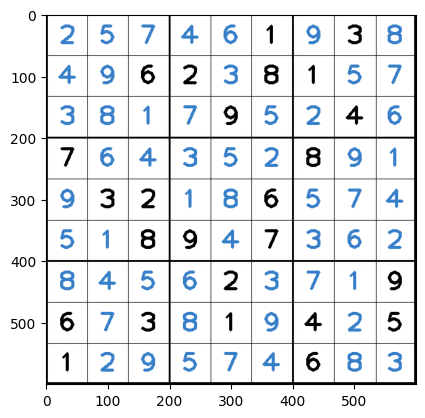

In [19]:
start = time.time()
solved_img = solve_sudoku_with_image(sudoku, TEMPLATE_FILENAME)
end = time.time()
plt.imshow(solved_img);
print(f'Solved in {int((end - start) * 1000)}ms')
plt.savefig('./docs/fig5.jpg', dpi=400)